## Relative Strength Index (RSI)
RSI is a momentum oscillator that measures speed and magnitude of recent price changes to evaluate overbought and oversold conditions in a market.

### Typical settings
N = 14 is standard 14-day RSI
and RSI ranges from 0 to 100

### Signals
- RSI > 70 -> Assets may be overbought (indicates overvalued and value will fall) exit trade
- RSI < 30 -> Assets may be oversold (indicates undervalued and value will rise) enter trade

### Calculation
1. Price Change
$\Delta{Price} = Close_t - Close_{t - 1}$
2. Gains and Losses
- $Gain = max(\Delta{Price}, 0)$
- $Loss = - min(\Delta{Price}, 0)$
3. Average Gain and Loss(Smoothed using EMA or rolling mean)
$Avg Gain_{\text{14 days}}, Avg Loss_{\text{14 days}}$
4. Relative Strength (RS)
$ RS = \dfrac{\text{Avg Gain over N periods}}{\text{Avg Loss over N periods}}$
5. RSI Formula
$ RSI = 100 - \dfrac{100}{1+RS}$





In [13]:
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

C:\Users\devpa\AppData\Local\Temp\ipykernel_16344\427414454.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=TICKER, period="max")
[*********************100%***********************]  1 of 1 completed


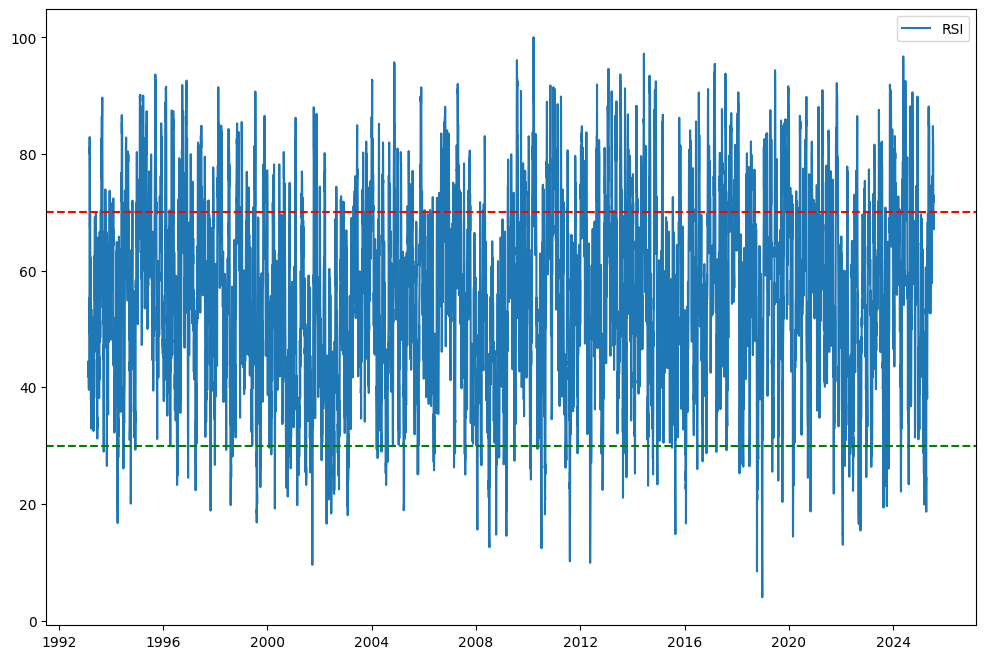

Shows the postions we will be short(-1) and long(1) Strategy
 0    6175
-1    1592
 1     396
Name: count, dtype: int64


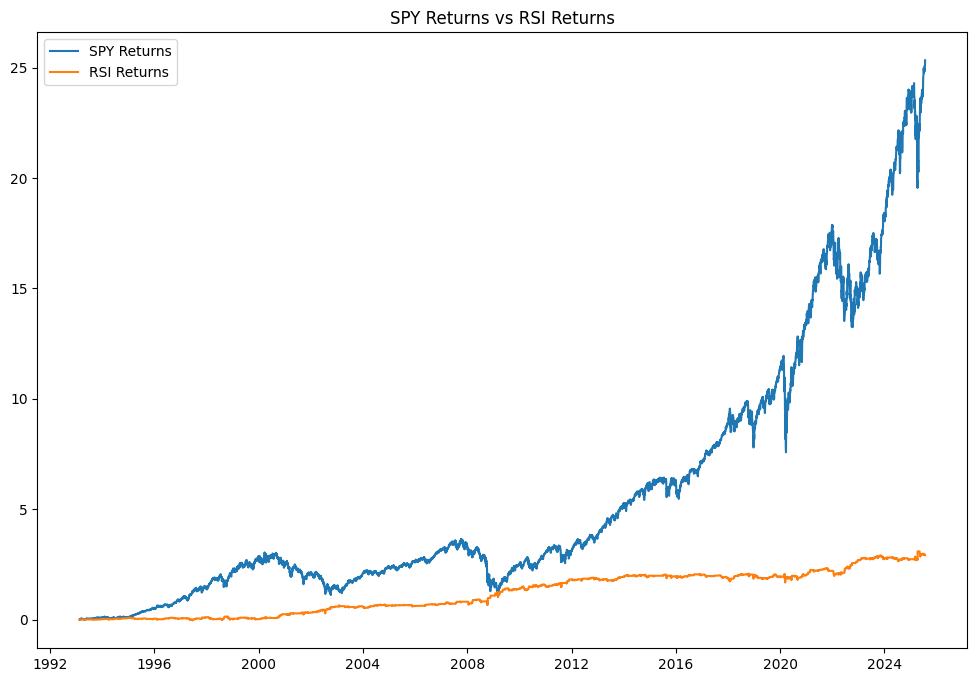

In [50]:
TICKER = 'SPY'
RSI_LENGTH = 14
OVERVALUED = 70
UNDERVALUED = 30
LOOKBACK = 10000

def get_data():
    df = yf.download(tickers=TICKER, period="max")
    df.columns = df.columns.get_level_values(0) # flatten df
    return df.iloc[-LOOKBACK:, :]

def add_RSI(df, length = RSI_LENGTH):
    # price_change is the change is close price from the previous day
    price_change = df["Close"].diff()
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # avg gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # relative strength
    rs = avg_gain / avg_loss
    # relative strength index
    rsi = 100 - (100 / (1 + rs))
    df["RSI"] = rsi
    plt.figure(figsize = (12, 8))
    plt.plot(df["RSI"], label="RSI")
    plt.axhline(y=OVERVALUED, color="r", linestyle="--")
    plt.axhline(y=UNDERVALUED, color="g", linestyle="--")
    plt.legend()
    plt.show()
    return df.dropna()

# if a security is undervalue we by them and if they are overvalued we sell them
def add_strategy(df, overbought=OVERVALUED, oversold=UNDERVALUED):
    df["Strategy"] = 0
    df["Strategy"] = np.where(df["RSI"] > overbought, -1,
                        np.where(df["RSI"] < oversold, 1, 0))
    print("Shows the postions we will be short(-1) and long(1)",df["Strategy"].value_counts())
    # shift back to see that we see the signal
    df["Strategy"] = df["Strategy"].shift(1)
    return df

def test_strategy(df):
    df["Asset Returns"] = np.cumprod(1 + df["Close"].pct_change()) - 1
    df["Strategy Returns"] = np.cumprod(1 + df["Close"].pct_change() * df["Strategy"]) - 1
    plt.figure(figsize = (12, 8))
    plt.plot(df["Asset Returns"], label=f"{TICKER} Returns")
    plt.plot(df["Strategy Returns"], label=f"RSI Returns")
    plt.title(f"{TICKER} Returns vs RSI Returns")
    plt.legend()
    return df
def main():
    df = get_data()
    df = add_RSI(df)
    df = add_strategy(df)
    df = test_strategy(df)
    return df

df = main()

#### As shown in the graph the strategy gives positive returns but does the outperform the stock itself as it has no idea regarding the actual trends of the markets.